# RP3 Strategy
Classic volatility targetted risk premia strategy using 3 instruments

Define imports and strategy parameters

In [47]:
import datetime
import math
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

# Map asset class to instrument
equity_ticker = 'VDNR.L'
bond_ticker = 'IBTL.L'
gold_ticker = 'SGLN.L'
universe_tickers = [equity_ticker, bond_ticker, gold_ticker]

# Assetwise volatility targets
equity_vol_target = 0.03
bond_vol_target = 0.03
gold_vol_target = 0.03

# Portfolio re-balance threshold at % of vol target
rebalance_vol_threshold = 0.2

# Calendar days to load data for each asset class
hist_price_period_days = 5 * 365

# Day periods to use for volatility estimation
vol_forecast_period_days = 60

# Portfolio positions
cash_value = 1000
equity_pf_qty = 10
bond_pf_qty = 0
gold_pf_qty = 0

Load historic adjusted close prices for our universe for last x days covering the volatility forecast period

In [48]:
# Set period to load data, noting these are calendar days not trading days
period = datetime.datetime.utcnow()
period_start = period - datetime.timedelta(days=hist_price_period_days)

# Get daily adjusted close data from Yahoo Finance for our universe
asset_df = pdr.get_data_yahoo(universe_tickers, start=period_start, end=period)[['Adj Close']]

# Standardize names
asset_df = asset_df.reset_index()
asset_df = asset_df.rename_axis(columns={'Attributes': 'attribute', 'Symbols': 'ticker'})
asset_df = asset_df.rename(columns={'Date': 'date', 'Adj Close': 'price'})

# Save price data to local feather file
feather_prep_df = asset_df.copy()
feather_prep_df.columns = feather_prep_df.columns.map(str)
feather_prep_df.to_feather("./prices.feather")

asset_df.tail(5)


attribute       date       price                    
ticker                    VDNR.L      IBTL.L  SGLN.L
1258      2022-08-17  104.230003  353.149994  2853.0
1259      2022-08-18  104.544998  356.899994  2860.0
1260      2022-08-19  103.157501  354.649994  2885.0
1261      2022-08-22  101.510002  354.299988  2875.5
1262      2022-08-23  100.870003  353.500000  2875.0

Enrich our dataframe of historic prices with further metrics required by the strategy

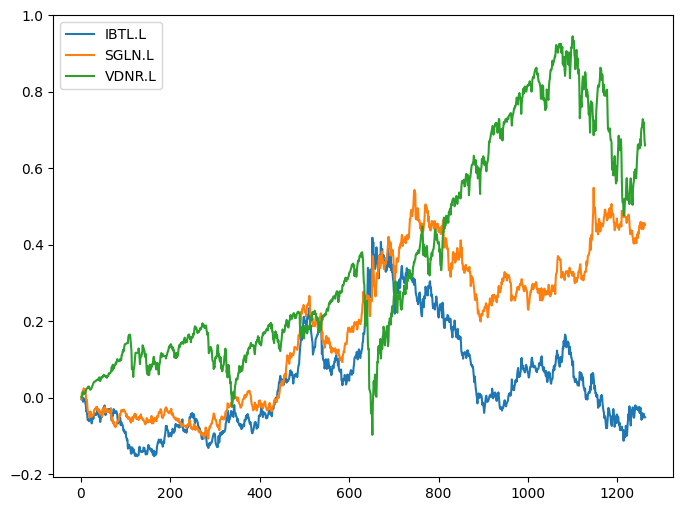

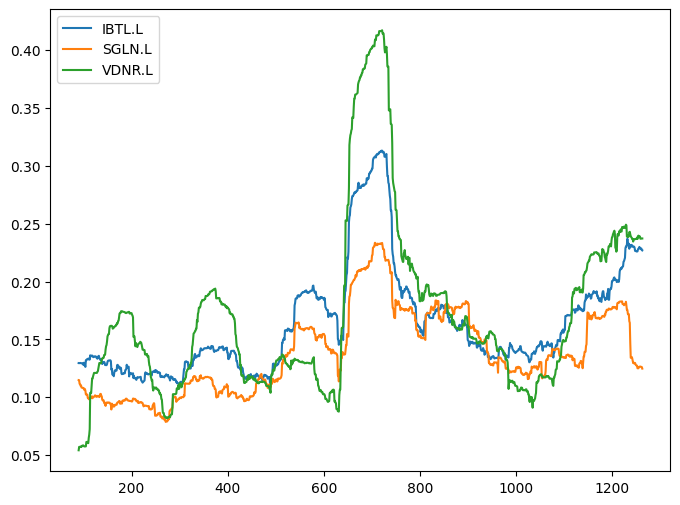

In [49]:
for ticker in universe_tickers:
    # Calculate total returns
    asset_df['return', ticker] = asset_df['price', ticker].pct_change()
    asset_df['log_return', ticker] = np.log(asset_df['price', ticker]/asset_df['price', ticker].shift(1))
    asset_df['cum_return', ticker] = (1 + asset_df['return', ticker]).cumprod() - 1
    asset_df['cum_log_return', ticker] = asset_df['log_return', ticker].cumsum()

    # Calculate rolling annual volatility for key periods
    asset_df['rolling_xd_ann_vol', ticker] = asset_df['log_return', ticker].rolling(vol_forecast_period_days).std() * math.sqrt(252)
    asset_df['rolling_30d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(30).std() * math.sqrt(252)
    asset_df['rolling_60d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(60).std() * math.sqrt(252)
    asset_df['rolling_90d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(90).std() * math.sqrt(252)

asset_df = asset_df.sort_index(axis='columns', level=1)

asset_df['cum_return'].plot(figsize=(8,6))
plt.legend(loc=2)

asset_df['rolling_90d_ann_vol'].plot(figsize=(8, 6))
plt.legend(loc=2)


Now compute unconstrained position sizes based on annualized volatility for each instrument

In [50]:
latest_df = asset_df.tail(1)
equity_price = latest_df['price', equity_ticker].values[0]
bond_price = latest_df['price', bond_ticker].values[0]
gold_price = latest_df['price', gold_ticker].values[0]
portfolio_nav = cash_value + (equity_pf_qty * equity_price) + (bond_pf_qty * bond_price) + (gold_pf_qty * gold_price)

portfolio_df = pd.DataFrame({
    'ticker': universe_tickers,
    'pf_qty': [equity_pf_qty, bond_pf_qty, gold_pf_qty],
    'vol_target': [equity_vol_target, bond_vol_target, gold_vol_target],
    'price': [equity_price, bond_price, gold_price],
    'vol': [
        latest_df['rolling_xd_ann_vol', equity_ticker].values[0],
        latest_df['rolling_xd_ann_vol', bond_ticker].values[0],
        latest_df['rolling_xd_ann_vol', gold_ticker].values[0],
        ]
})

portfolio_df['target_qty'] = (portfolio_df['vol_target'] / portfolio_df['vol']) * (portfolio_nav / portfolio_df['price'])
portfolio_df['delta_qty'] = (portfolio_df['target_qty'] - portfolio_df['pf_qty'])



#vol = latest_prices_df['rolling_ann_vol', 'VDNR.L'].values[0]
#size = (equity_vol_target / vol) * (cash_value / last_price)


#print(last_price)
#print(vol)
#print(size)

portfolio_df


,ticker,pf_qty,vol_target,price,vol,target_qty,delta_qty
0,VDNR.L,10,0.03,100.870003,0.226195,2.641138,-7.358862
1,IBTL.L,0,0.03,353.500000,0.225446,0.756142,0.756142
2,SGLN.L,0,0.03,2875.000000,0.120249,0.174308,0.174308
